# Tutorial Part 3: Local indexing

In the previous tutorial, we saw how to sort diffraction data from complex samples featuring multiple phases and produce a 2D phase map with phase labels on each pixel. We introduced a new class Pixelmap to store and plot properties on 2D pixel grid. At the end of Tutorial 002, we obtained a labeled phase map, with a phase id assigned to each pixel, and a filtered peakfile '*_pks_p_flt.h5', with a new column 'phase_id' to assign a phase to each diffraction peak. 

Now, we want to find the local orientation of each pixel, ie. fit a rotation matrix U corresponding to crystal orientation on each point of the map. This process is called local indexing. What we want to do here is to fit unit cell matrices $UBI = (U.B)^{-1}$ on each pixel, using the set of lattice vectors assigned to this pixel. Then, $U$ is the crystal orientation and $B$ the matrix of reciprocal unit cell vectors. 

***

### Load packages

In [5]:
# general modules
import os, sys, glob
import h5py
import pylab as pl
import numpy as np
import concurrent.futures, multiprocessing
from tqdm import tqdm

# ImageD11 https://github.com/FABLE-3DXRD/ImageD11
import ImageD11.sinograms.dataset
import ImageD11.columnfile
import ImageD11.parameters
import ImageD11.indexing
import ImageD11.grain
import ImageD11.sym_u

# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')    

from pf_3dxrd import utils, friedel_pairs, pixelmap, crystal_structure, peak_mapping

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

### Load data
We need the filtered peakfile and the pixelmap we saved in the previous step. Local indexing is done separately for each phase, because each one has its own symmetry and unit cell of reference. Therefore, we also to filter the peakfile by phase_id at the same time. Once one phase has been indexed on the whole map, the process can be repeated for the second phase, etc. 

In [6]:
def load_data(dset, parfile, pname, detector='frelon'):
    # paths
    pksfile = os.path.join(data_dir, dsname+'_pks_p_flt.h5')
    dsfile  = pksfile.replace('pks_p_flt','ds')
    xmapfile = pksfile.replace('pks_p_flt','xmap')

    # load pixelmap
    xmap = pixelmap.load_from_hdf5(xmapfile)
    print(xmap)
    # crystal structure we want to index
    cs = xmap.phases.get(pname)
    pid = cs.phase_id
    
    # load cf  + keep only peaks from the phase we want to index
    cf = ImageD11.columnfile.columnfile(pksfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    friedel_pairs.update_geometry_s3dxrd(cf, detector=detector, update_gvecs=True)
    cf.filter(cf.phase_id==pid)
    utils.get_colf_size(cf)
    
    # add pixel labeling to cf + sort by pixel index
    peak_mapping.add_pixel_labels(cf, ds = ImageD11.sinograms.dataset.load(dsfile))
    cf.sortby('xyi')
    
    return xmap, cf, cs


In [7]:
# paths

data_dir = 'wg_data'
dsname = 'SI3_DT360Z5480'
parfile='wg_data/SI3.par'

# select phase to index. Thsi must be of course in the list of phases added in pixelmap
pname = 'quartz'
#dsname = 'WG102_2000um'
#parfile  ='wg_data/WG102.par'

In [8]:
# load data
xmap, cf, cs = load_data(dsname, parfile, pname, detector = 'frelon')

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Cind', 'Npks', 'U', 'UBI', 'U_g', 'ci', 'drlv2', 'misorientation', 'nindx', 'phase_id_raw', 'strain_Lab_d_eigvals', 'strain_Lab_d_eigvecs', 'strain_Lab_d_voigt', 'strain_Lab_vM', 'strain_Lab_voigt', 'strain_Lab_vol', 'stress_Lab_P_hyd', 'stress_Lab_d_eigvals', 'stress_Lab_d_eigvecs', 'stress_Lab_d_voigt', 'stress_Lab_vM', 'stress_Lab_voigt', 'ui', 'unitcell'], 
 grains: 40
Reading your columnfile in hdf format
Total size =  81.34 MB


Note that crystal structures have been saved in the pixelmap file when saving at the end of Tutorial 002, so they don't need to be imported again from cif files. 

In [9]:
print(xmap.phases.quartz)

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [4.91921, 4.91921, 5.41186, 90.0, 90.0, 120.0]


### Local indexing

The fitting process is done with the big function pixel_ubi_fit below. The goal is to find for each pixel the best unit cell matrix ($UBI$) matching with 
reciprocal lattice vectors (g-vectors) assigned to this pixel. It uses the *indexer* module from ImageD11 to find a list of possible unit cell matrices ($UBI$) candidates. Then each matrix is scored, and the matrix with the best score is assigned to the pixel. The score is defined using the number of peaks assigned to each unit cell matrix (the higher, the better) and drlv2, whiche measures the deviation between theoretical and measured (h,k,l) for each peak: drlv2 = (h-int(h))² + (k-int(k))² + (l-int(l))² (the lower the better).



In [13]:
def pixel_ubi_fit( px, **kwargs ):
    """ 
    fit ubi pixel-by-pixel. a list of possible UBI matrices matching with g-vectors over the selected pixel is found runing
    ImageD11.indexing. Then, each ubi is scored and the best-matching one is retained.
    
    unitcell: crystal unit cell to pass to ImageD11.indexer
    symmetry: crystal symmetry (ImageD11.sym_u symmetry) to keep only unique orientations
    hkltol  : hkl tolerance for indexing (see ImageD11.indexing)
    minpks  : minimum number of g-vectors to consider a ubi as a possible match (see ImageD11.indexing)
    minpks_prop : minimum fraction of g-vectors over the selected pixel to consider a ubi as a possible match.
    max_mult : maximum multplicity of hkl rings in which possible orientation match will be searched. 
    nrings_max : maximum number of hkl rings to search in 
    
    outputs:
    best_ubi : best UBI matrix
    best_score : score of best_ubi. Tuple (nindx, drlv2), where nindx is the number of g-vectors assigned to best_ubi and
    drlv2 the mean square deviation from the closest integer hkl indices for assigned g-vectors
    """
    # extract keyword arguments
    unitcell    = kwargs['unitcell']      # crystal unit cell to pass to ImageD11.indexer
    symmetry    = kwargs['sym']           # crystal symmetry (ImageD11.sym_u symmetry) to find unique orientations
    hkltol      = kwargs['hkltol']        # hkl tolerance parameter for indexing (see ImageD11.indexing)
    minpks      = kwargs['minpks']        # minimum number of g-vectors to consider a ubi as a possible match (see ImageD11.indexing)
    minpks_prop = kwargs['minpks_prop']   # minimum fraction of g-vectors over the selected pixel to consider a ubi as a possible match.
    max_mult    = kwargs['max_mult']      # maximum multplicity of hkl rings in which possible orientation match will be searched. 
    nrings      = kwargs['nrings']        # maximum number of hkl rings to search in 
    ks          = kwargs['px_kernel_size'] # size of peak selection around a pixel: single pixel or kernel selection
    
    # select peaks from px
    s = peak_mapping.pks_from_px(to_index.xyi, px, kernel_size=ks)
    if len(s) == 0:
        return px, -1, 0, []
 
    # prepare indexer
    ###########################################################################
    gv = np.array( (to_index.gx[s],to_index.gy[s],to_index.gz[s])).T.copy()
    ImageD11.indexing.loglevel=10  # loglevel set to high value to avoid outputs from indexer
    ind = ImageD11.indexing.indexer( unitcell = unitcell,
                                     gv = gv,
                                     wavelength=to_index.parameters.get('wavelength'),
                                     hkl_tol= hkltol,
                                     cosine_tol = np.cos(np.radians(90-1.)),
                                     ds_tol = 0.005,
                                     minpks = max(minpks, len(gv) * minpks_prop),
                                      )
    # assigntorings sometimes return errors, for a reason that is unclear to me. handle this with an exception and return empty pixel (no ubi indexed)
    try:
        ind.assigntorings()
    except Exception as e:
        print('something went wrong with indexer.assigntorings()')
        return px, [], []

    # find possible ubis
    ###########################################################################
    # list of hkl rings to search in
    rings = [] 
    for i, ds in enumerate(ind.unitcell.ringds[:nrings]): # select first nrings
        if len(ind.unitcell.ringhkls[ds]) <= max_mult and (ind.ra == i).sum()>0:  # select low multiplicity rings with nonzero nb of peaks
            rings.append(i)
    if len(rings)==0:   # if no rings with peaks, return empty output (notindexed)
        return px, [], []  
    
    # loop through rings and try to match ubis
    for r1 in rings[::-1]:
        for r2 in rings[::-1]:
            ind.ring_1 = r1
            ind.ring_2 = r2
            ind.find()
            if ind.hits is None or len(ind.hits) == 0:
                continue
            ind.scorethem()

    # no ubi found
    if len(ind.ubis) ==0:
        return px, [], []
    
    # Refinement, scoring and selection of best ubi
    ###########################################################################    
    scores = []        # score = (npks_index, mean_drlv2) for each ubi found
    scoreproduct = []  # defined as npks_indexed/mean_drlv2. The higher the better
    ubis = []          # write refined ubit to new list
    
    # compute scores for all ubis found
    for i,ubi in enumerate(ind.ubis):
        sc = ImageD11.cImageD11.score_and_refine( ubi, gv, hkltol ) 
        scores.append(sc)
        scoreproduct.append(sc[0]/sc[1])
        ubis.append( ImageD11.sym_u.find_uniq_u( ubi, symmetry ) )
    
    if len(ubis) == 0:   # no ubi found
        return px, [], []
    # select the best ubi: highest scoreproduct
    nindx = [sc[0] for sc in scores]
    best_score = scores[np.argmax(scoreproduct)]
    best_ubi = ubis[np.argmax(scoreproduct)]
    
    return px, best_ubi, best_score



#### prepare for indexing

Before running the pixel_fit_ubi function, we will create a separate temporay file containing the g-vectors to index and save it. Then , multiple processes will be able to access these data at the same time. Optionally, it is possible to filter the g-vectors to index (e.g. filter by intensity to index only the strongest peaks). 

In [14]:
# save g-vectors to index in a temporary file
# g-vectors to index. take only usefl columns
to_index = ImageD11.columnfile.colfile_from_dict( { name: cf.getcolumn(name) for name in 'gx gy gz xyi sum_intensity'.split() } )

# optional : filter to remove some weak peaks
to_index.filter(to_index.sum_intensity > 50)

# osrt by pixel index and save
to_index.sortby('xyi')
utils.colf_to_hdf(to_index, 'toindex.h5', save_mode='full')

The function pixel_ubi_fit needs to be run on each pixel of the map corresponding to the selected phase. This corresponds to the list of unique pixel indexes (xyi) in the filtered peakfile. 

It is usually a good idea to first try local indexing on a small subset of the map to see how it looks and adjust indexing parameters if needed. Then, once you are satisfied with indexing parameters, you can run local indexing on the whole map.

The code below shows how to select either all pixels on the map, or a small rectangle. 

In [15]:
# FULL MAP
xyi_uniqs = np.unique(cf.xyi)

# RECTANGULAR SUBSET: uncomment these lines if you want to index only a subset of the map
#sel = utils.select_subset(cf, 'rectangle', xmin = 1, xmax=2, ymin=0,ymax=1)
#xyi_uniqs = np.unique(cf.xyi[sel])

There are a few parameters to set up for indexing, all in the kwarg dictionnary below. 
- unitcell : read directly from crystal structure loaded in input
- sym     : crystal symmetry as ImageD11.sym_u object
- minpks  : minimum number of peaks to consider a UBI candidate as valid
- minpks_prop : minimum proportion of peaks over the pixel to consider a UBI candidate as valid. The minpks parameter passed to indexer is then 
max(minpks, len(gvecs) * minpks_prop)
- max_mult: maximum multiplicity of hkl rings in which potential orientation match are tested
- nrings : maximum number of hkl rings to test to find potential UBI candidates
- px_kernel_size : size of the pixel kernel for peak selection. When set to 1, correspond to a single pixel selection

As a general rule, start with low max_mult, nrings and hkltol, and set px_kernel size to 1. If the output is noisy, try increasing max_mult, nrings and try with a larger kernel size, untile you are satisfied with the output. If the map looks incomplete, relaxing a bit the minpks and /or hkltol parameters can help. 

In [16]:
# keywork arguments to pass to pixel_ubi_fit function
kwargs = {'unitcell'   : ImageD11.unitcell.unitcell( cs.cell , cs.lattice_type),
          'sym'        : ImageD11.sym_u.hexagonal(),
          'hkltol'     : 0.15,
          'minpks'     : 10,
          'minpks_prop': 0.1,
          'max_mult'   : 12,
          'nrings'     : 15,
          'px_kernel_size' : 1}

print(f'Number of pixels to process: {len(xyi_uniqs)}')


# number of cpus
ncpu = len(os.sched_getaffinity( os.getpid() ))
print(f'ncpu: {ncpu}')

Number of pixels to process: 2441
ncpu: 10


#### Run local indexing in parallel

Now everything is set up, we can run indexing in parallel. Results are stored in a temporary dictionnary. Then we will unpack these results and update the pixelmap. 

In [17]:
# func wrapper: wrap args and kwargs
def func_wrapper(px):
    return pixel_ubi_fit(px, **kwargs)

def doinit():
    # initialization function for ProcessPoolExecutor
    global to_index
    ImageD11.cImageD11.cimaged11_omp_set_num_threads(1)
    to_index = ImageD11.columnfile.colfile_from_hdf( './toindex.h5' )
    to_index.parameters.loadparameters(parfile)
    to_index.xyi = to_index.xyi.astype(int)   # convert xyi to default int type, otherwise peaksearch takes forever
    utils.update_colf_cell(to_index, cs.cell, cs.spg, cs.lattice_type, mute=True)  


In [18]:
# multiprocessing loop
results = {}

if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor() as pool:
        pool.max_workers=max(ncpu-1,1)
        pool.initializer = doinit(),
        pool.mp_context=multiprocessing.get_context('fork')
        
        
        for r in tqdm(pool.map( func_wrapper, xyi_uniqs, chunksize=20) ):
            results[r[0]] = r[1:]

2441it [00:30, 79.57it/s] 


#### Extract results and add them to pixelmap

Now the fitting process is completed. Result shave been written in a dictionnary 'results', which needs to be unpacked. The function update_xmap below takes the data from the result dictionnary and write them as new columns in the pixelmap. There are several parameters in this function, detailed in the docstring. 

In [22]:
def update_xmap(xmap, results, pname, drlv2_max = 0.1, overwrite = True):
    """ write indexing outputs in xmap. updates only pixels corresponding to the indexed phase. Also reset pixels to "notindexed" if no
    orientation has been found or if indexing scores are too bad (nindx < nindx_min, drlv2 > drlv2_max
    
    Args:
    xmap    : pixelmap in which results will be written
    results : output from fitting process
    pname   : name of the phase being indexed
    drlv2_max : max threshold for drlv2. If a UBI is identified on a pixel with drlv2 > drlv2_mx, the pixel will be kept unindexed. Avoids dodgy UBIs
    overwrite : if True, reset already all indexed pixels corresponding to the selected phase pname before writing new data. Useful when doing multiple tests
                on small subsets off the map
    """
    
    cs = xmap.phases.get(pname)
    pid = cs.phase_id
    
    # initialize new data arrays (and add them to xmap if not yet present)
    #####################################################################
    lx = xmap.xyi.shape
    #initialization
    dnames = 'nindx drlv2 U UBI unitcell'.split(' ')
    dshapes = [lx, lx, lx+(3,3), lx+(3,3), lx+(6,)]
    initvals = [-1, -1, -1, -1, 0]
    dtypes = [np.int32, np.float64, np.float64, np.float64, np.float64]
    
    data_dict = dict( zip(dnames, [ [] for _ in range(len(dnames)) ]) )  # results reorganized by data columns in a dictionnary
    
    # add arrays to xmap if not yet present
    for n,shp,ival,dt in zip(dnames, dshapes, initvals, dtypes):
        ary = np.full(shp, ival, dt)               
        if n not in xmap.titles():   
            print(n, ary.shape)
            xmap.add_data(ary,n)
        
        if overwrite:
            sel = xmap.phase_id == pid
            xmap.update_pixels(xmap.xyi[sel], n, ary[sel])
    
    # reset indexing outputs for the working phase if overwrite is True
    if overwrite:
        sel = xmap.phase_id == pid
        
    
    # fill data dict
    #####################################################################
    print('extracting results...')
    xyi_to_update = []  # initialize list of pixels to update
    
    # read pixelmap pixel by pixel
    for k, (px,vals) in enumerate(tqdm(results.items())):  
        
        # skip pixels not corresponding to the phase being indexed
        if xmap.phase_id[xmap.xyi == px] != pid:
            continue
            #nindx, drlv2, U, UBI, uc = -1, -1, np.full((3,3), -1), np.full((3,3), -1), np.full(6,-1)

        # no ubi found for this pixel
        n_ubi = len(vals[0])  #nb of orientations found for this pixel
        if n_ubi == 0:
            nindx, drlv2, U, UBI, uc = -1, -1, np.full((3,3), -1), np.full((3,3), -1), np.full(6,-1)
        
        else:
            nindx = vals[1][0]
            drlv2 = vals[1][1]
            if drlv2 > drlv2_max:
                nindx, drlv2, U, UBI, uc = -1, -1, np.full((3,3), -1), np.full((3,3), -1), np.full(6,-1)
    
            # compute grain properties and add them to data_dict
            try:
                g = ImageD11.grain.grain(vals[0])
                UBI, U, uc = g.ubi, g.U, g.unitcell
            except Exception as e:   
                print('dodgy ubi')
                nindx, drlv2, U, UBI, uc = -1, -1, np.full((3,3), -1), np.full((3,3), -1), np.full(6,-1)
            
        xyi_to_update.append(px)
        data_dict['nindx'].append(nindx)
        data_dict['drlv2'].append(drlv2)
        data_dict['UBI'].append(UBI)
        data_dict['U'].append(U)
        data_dict['unitcell'].append(uc)

        
    # update xmap
    #####################################################################
    print('updating pixemap data columns...')
    
    # update xmap data columns except strain_px
    for dname, newvals in data_dict.items():        
        newvals = np.array(newvals)
        xmap.update_pixels(xyi_to_update, dname, newvals)


By default, update_xmap resets all pixels of the selected phase (overwrite = True). You can also choose not to touch previously indexed pixels, and write only data where nothing has been indexed (not recommended). Pixels belonging to other phases will not be touched, so you do not risk to overwrite a previously indexed phase.

In [23]:
update_xmap(xmap, results, pname, drlv2_max = 0.1, overwrite = True)

extracting results...


100%|██████████| 2441/2441 [00:00<00:00, 20141.76it/s]

updating pixemap data columns...


Now let's have a look at the new data in xmap

In [24]:
print(xmap)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Cind', 'Npks', 'U', 'UBI', 'U_g', 'ci', 'drlv2', 'misorientation', 'nindx', 'phase_id_raw', 'strain_Lab_d_eigvals', 'strain_Lab_d_eigvecs', 'strain_Lab_d_voigt', 'strain_Lab_vM', 'strain_Lab_voigt', 'strain_Lab_vol', 'stress_Lab_P_hyd', 'stress_Lab_d_eigvals', 'stress_Lab_d_eigvecs', 'stress_Lab_d_voigt', 'stress_Lab_vM', 'stress_Lab_voigt', 'ui', 'unitcell'], 
 grains: 40


There are several new columns: 'nindx', 'drlv2', UBI', 'U', 'unitcell'. nindx and drlv2 are indexing statistics returned by the function score_and_refine from cImageD11. nindx is the number of peaks retained for the best-matching $UBI$. drlv2 is the deviation between computed hkl indices for a g-vector and the closest integer values: drlv2 =  (h-int(h))² + (k-int(k))² + (l-int(l))². The drlv2 value written in xmap is the mean drlv2 of all indexed peaks over each pixel.

'UBI' is the unit cell matrix (each column is a unit cell vector in real space). U is the crystal rotation matrix giving the grain orientation in sample reference frame. unitcell is a (6,1) array containing fitted unit cell parameters, computed from the B matrix. 

### Plot
Let's plot these data. 

Orientation U is plotted using inverse pole figure colors. The idea of inverse pole figure color coding is to visualize the orientation of a grain by a color, corresponding to the orientation of the crystal face pointing towards a specific direction in the reference. By default, it is pointing toward you (z axis), but you can compute a color key for different directions, using the ipfdir parameter. 

The orientation color map assigns a unique color to each unique crystal orientation, accounting for symmetrically-equivalent orientations. There are many ways to define a color map (see https://mtex-toolbox.github.io/EBSDIPFMap.html). The built-in method in pixelmap uses the orix library (https://orix.readthedocs.io/en/stable/), which uses a TSL color key. This is maybe not the best choice, but so far it is the only one available in orix.

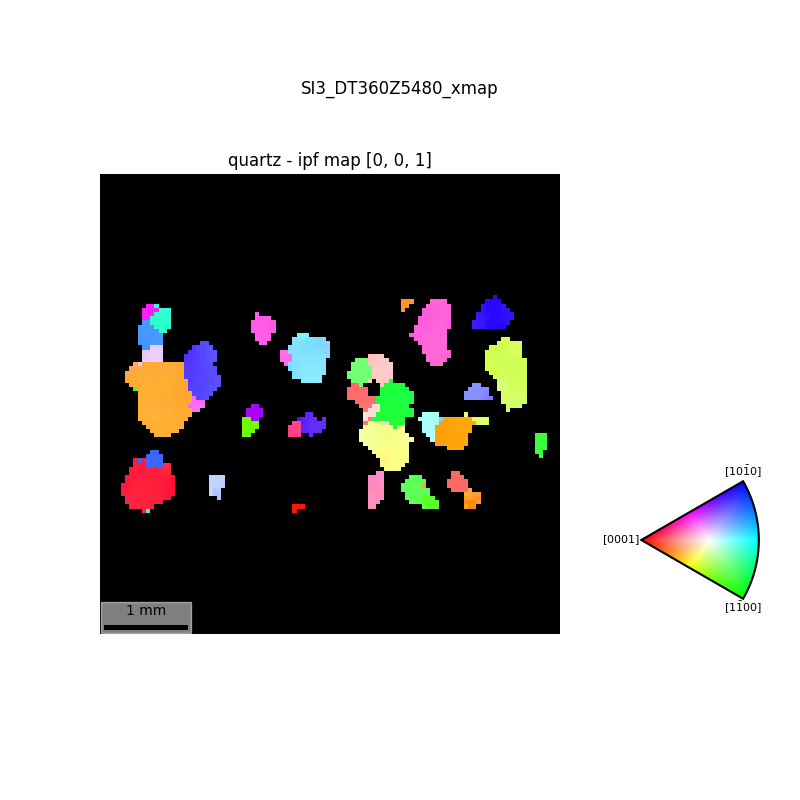

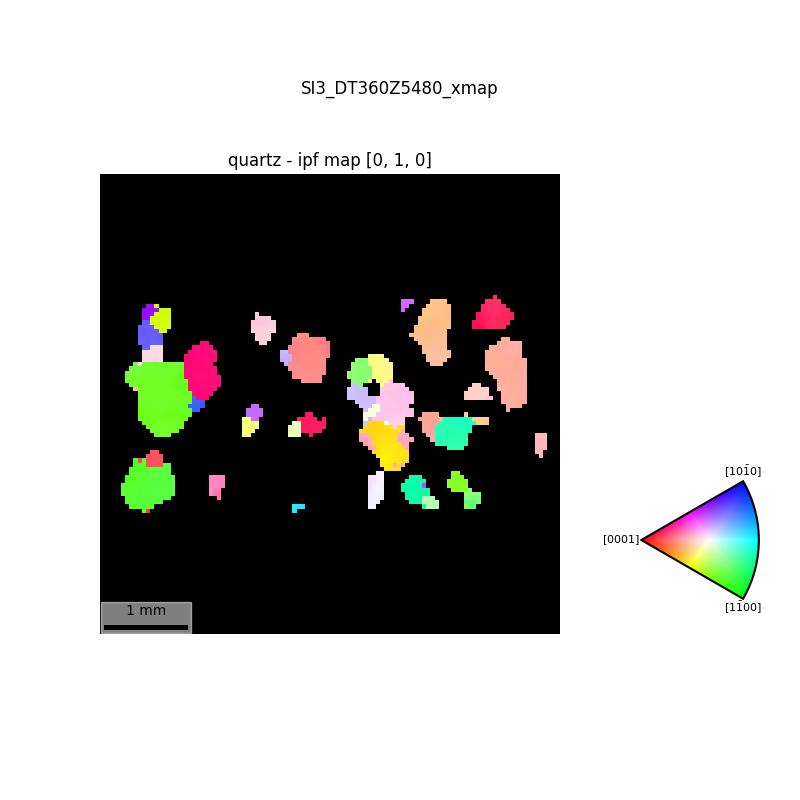

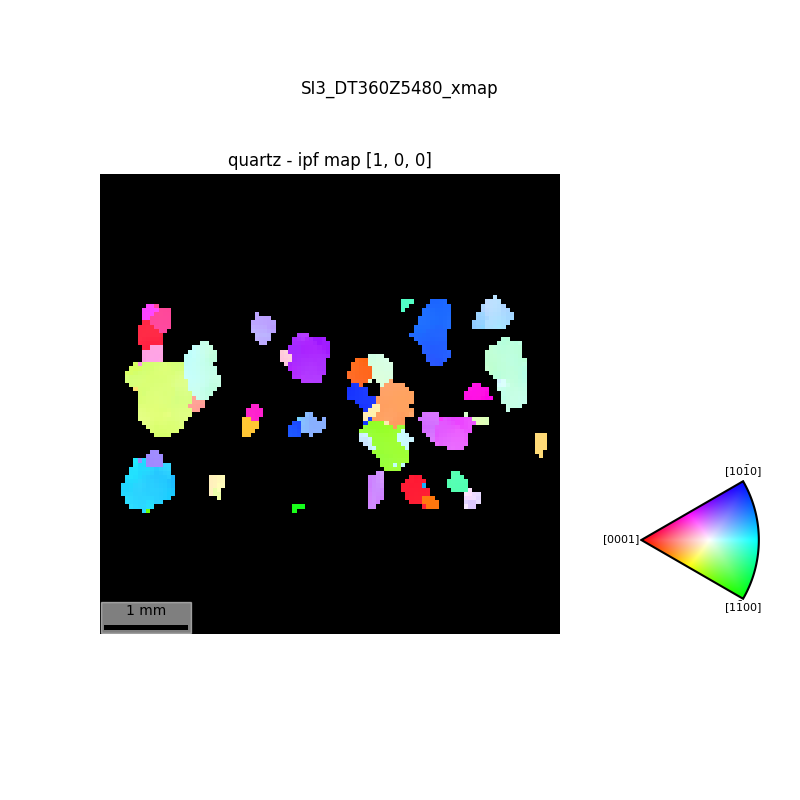

In [25]:
save=False

xmap.plot_ipf_map(pname, ipfdir = [0,0,1], save=save, hide_cbar=False, out=False)
xmap.plot_ipf_map(pname, ipfdir = [0,1,0], save=save, hide_cbar=False, out=False)
xmap.plot_ipf_map(pname, ipfdir = [1,0,0], save=save, hide_cbar=False, out=False)

We can also plot other outputs:

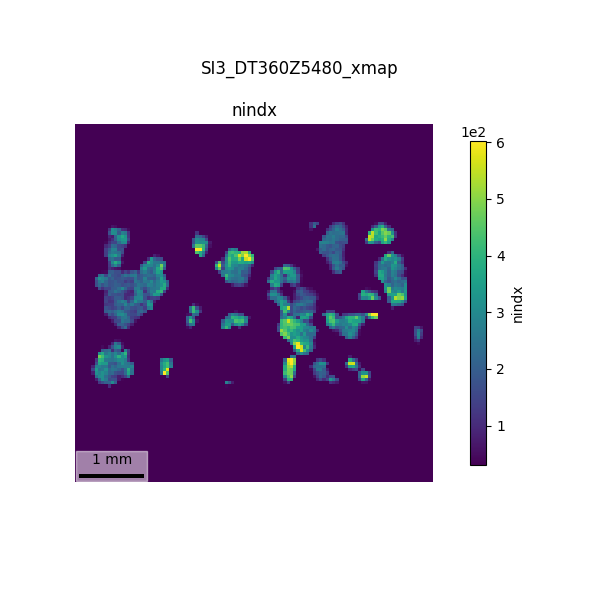

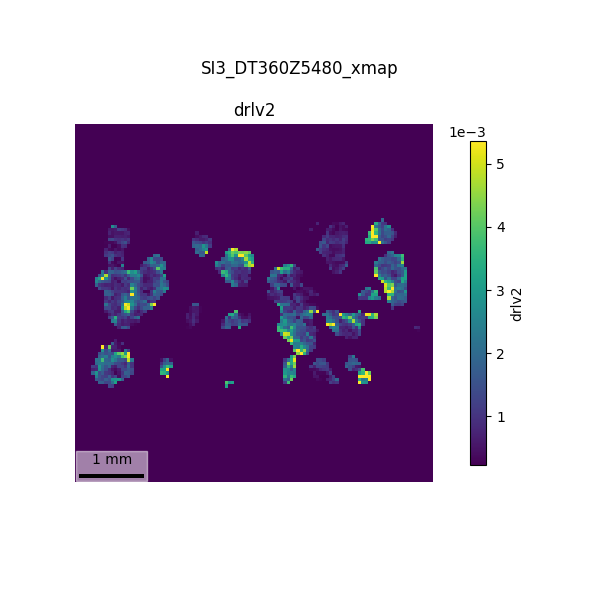

In [28]:
save=False
var_to_plot = ['nindx','drlv2']
kw = {'cmap':'viridis'}

for var in var_to_plot:
    xmap.plot(var, autoscale=True, save=save, **kw)

### Save pixelmap

Don't forget to save indexing results when you are satisfied with the map. There is just the pixelmap to save here, nothing has been added to the peakfile

In [ ]:
xmap.save_to_hdf5()